# Convolutions

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

mpl.rcParams['image.cmap'] = 'gray'

In [2]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a *convolution*. A convolution requires nothing more than multiplication, and addition.

<img src="images/chapter9_conv_basic.png" id="basic_conv" caption="Applying a kernel to one location" alt="Applying a kernel to one location" width="700">

### Understanding the Convolution Equations

To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Here's the input:

<img alt="The image" width="75" src="images/att_00032.png">

Here's our kernel:

<img alt="The kernel" width="55" src="images/att_00033.png">

Since the filter fits in the image four times, we have four results:

<img alt="The activations" width="52" src="images/att_00034.png">

<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="images/att_00035.png">

<img alt="The equation" width="436" caption="The equation" id="eq_view" src="images/att_00036.png">

In [3]:
x_imgs = x_train.view(-1,28,28)

In [69]:
def show_image(im, title=None, **kwargs):
    if not isinstance(im,np.ndarray): im=np.array(im)
    *_,x,y = im.shape
    plt.figure(figsize=(max(x//12,2),max(y//12,2)))
    plt.imshow(im, **kwargs)
    if title is not None: plt.title(title)
    plt.xticks([])
    plt.yticks([])

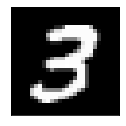

In [70]:
im3 = x_imgs[7]
show_image(im3)

In [6]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kernel (because that's what fancy computer vision researchers call these).

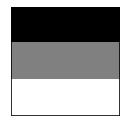

In [7]:
show_image(top_edge)

In [8]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$.

In [9]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [10]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [11]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [12]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

<img src="images/chapter9_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

In [13]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

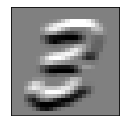

In [14]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3)

In [15]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

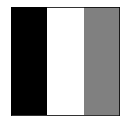

In [16]:
show_image(left_edge)

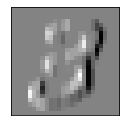

In [17]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3)

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/att_00028.png">

### Convolutions in PyTorch

In [18]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

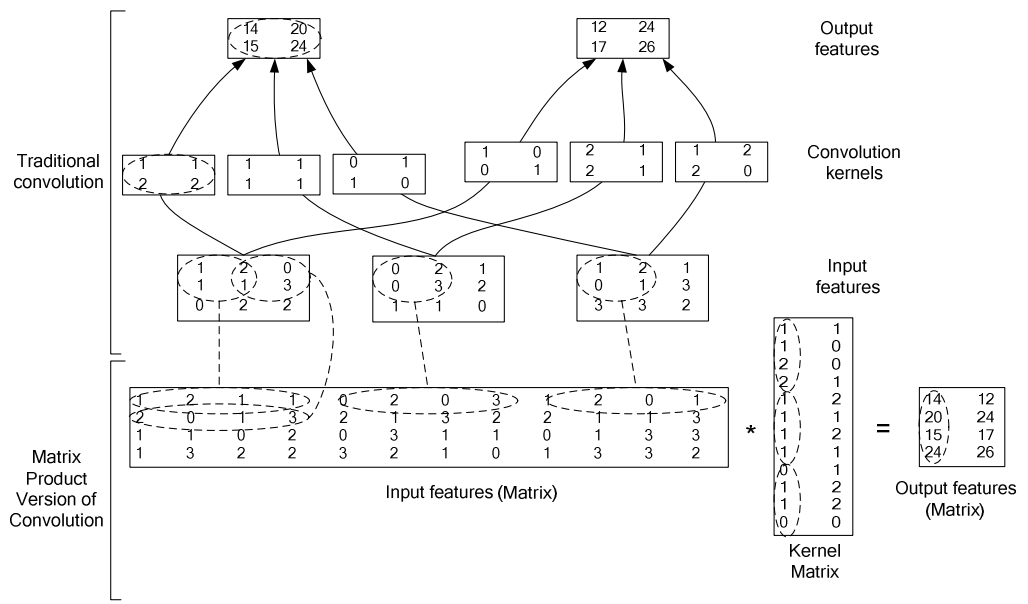

Here's a sample [numpy implementation](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360).

In [19]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [20]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [21]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

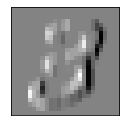

In [22]:
out = out_unf.view(26,26)
show_image(out)

In [23]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

5.81 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

23.3 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

13.7 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

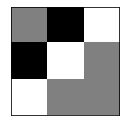

In [27]:
show_image(diag1_edge)

In [28]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

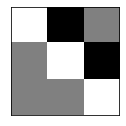

In [29]:
show_image(diag2_edge)

In [30]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [31]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [32]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

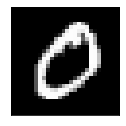

In [33]:
img0 = xb[1,0]
show_image(img0)

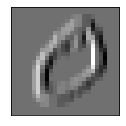

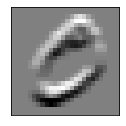

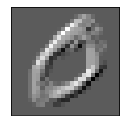

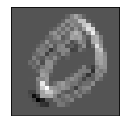

In [34]:
for i in range(4): show_image(batch_features[1,i])

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.

We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

## Creating the CNN

In [36]:
from torch import nn

In [38]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [39]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [42]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [43]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [46]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In [50]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,10, act=False), #1x1
    nn.Flatten(),
)

In [51]:
simple_cnn(xb).shape

torch.Size([16, 10])

### Understanding Convolution Arithmetic

We can see from the summary that we have an input of size `64x1x28x28`. The axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [56]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [57]:
conv1.bias.shape

torch.Size([4])

The *receptive field* is the area of an image that is involved in the calculation of a layer. *conv-example.xlsx* shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

The blue highlighted cells are its *precedents*—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click *trace precedents* again:

<img alt="Secondary precedents of conv2 layer" width="601" caption="Secondary precedents of Conv2 layer" id="preced2" src="images/att_00069.png">

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the *receptive field*

The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

## Color Images

A colour picture is a rank-3 tensor:

In [66]:
from torchvision.io import read_image

In [90]:
im = read_image('images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

In [91]:
def show_image(im, title=None, ax=None, **kwargs):
    if not isinstance(im,np.ndarray): im=np.array(im)
    *_,x,y = im.shape
    if ax is None: _,ax = plt.subplots(figsize=(max(x//12,2),max(y//12,2)))
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

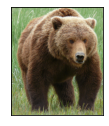

In [92]:
show_image(im.permute(1,2,0));

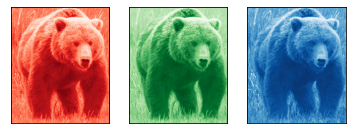

In [94]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

These are then all added together, to produce a single number, for each grid location, for each output feature.

<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Improving Training Stability

Since we are so good at recognizing 3s from 7s, let's move on to something harder—recognizing all 10 digits. That means we'll need to use `MNIST` instead of `MNIST_SAMPLE`:

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('testing'),Path('training')]

The data is in two folders named *training* and *testing*, so we have to tell `GrandparentSplitter` about that (it defaults to `train` and `valid`). We did do that in the `get_dls` function, which we create to make it easy to change our batch size later:

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

Remember, it's always a good idea to look at your data before you use it:

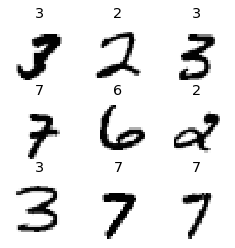

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

Now that we have our data ready, we can train a simple model on it.

### A Simple Baseline

Earlier in this chapter, we built a model based on a `conv` function like this:

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Let's start with a basic CNN as a baseline. We'll use the same one as earlier, but with one tweak: we'll use more activations. Since we have more numbers to differentiate, it's likely we will need to learn more filters.

As we discussed, we generally want to double the number of filters each time we have a stride-2 layer. One way to increase the number of filters throughout our network is to double the number of activations in the first layer–then every layer after that will end up twice as big as in the previous version as well.

But there is a subtle problem with this. Consider the kernel that is being applied to each pixel. By default, we use a 3×3-pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four output filters. That meant that there were four values being computed from nine pixels at each location. Think about what happens if we double this output to eight filters. Then when we apply our kernel we will be using nine pixels to calculate eight numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, if the number of outputs from an operation is significantly smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [ ]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

As you'll see in a moment, we can look inside our models while they're training in order to try to find ways to make them train better. To do this we use the `ActivationStats` callback, which records the mean, standard deviation, and histogram of activations of every trainable layer (as we've seen, callbacks are used to add behavior to the training loop; we'll explore how they work in <<chapter_accel_sgd>>):

In [ ]:
from fastai.callback.hook import *

We want to train quickly, so that means training at a high learning rate. Let's see how we go at 0.06:

In [ ]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.307071,2.305865,0.113500,00:16


This didn't train at all well! Let's find out why.

One handy feature of the callbacks passed to `Learner` is that they are made available automatically, with the same name as the callback class, except in `snake_case`. So, our `ActivationStats` callback can be accessed through `activation_stats`. I'm sure you remember `learn.recorder`... can you guess how that is implemented? That's right, it's a callback called `Recorder`!

`ActivationStats` includes some handy utilities for plotting the activations during training. `plot_layer_stats(idx)` plots the mean and standard deviation of the activations of layer number *`idx`*, along with the percentage of activations near zero. Here's the first layer's plot:

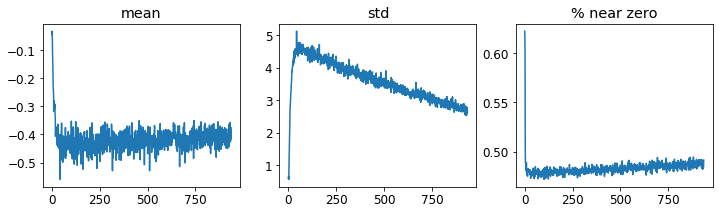

In [ ]:
learn.activation_stats.plot_layer_stats(0)

Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations during training. Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

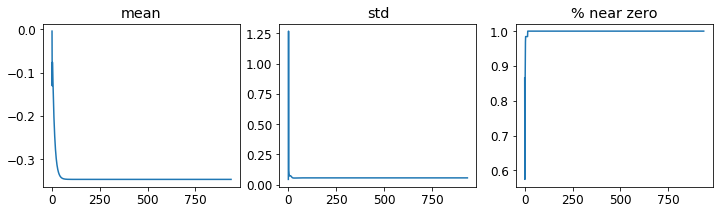

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers. Let's look at what we can do to make training more stable.

### Increase Batch Size

One way to make training more stable is to increase the batch size. Larger batches have gradients that are more accurate, since they're calculated from more data. On the downside, though, a larger batch size means fewer batches per epoch, which means less opportunities for your model to update weights. Let's see if a batch size of 512 helps:

In [ ]:
dls = get_dls(512)

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.309385,2.302744,0.113500,00:08


Let's see what the penultimate layer looks like:

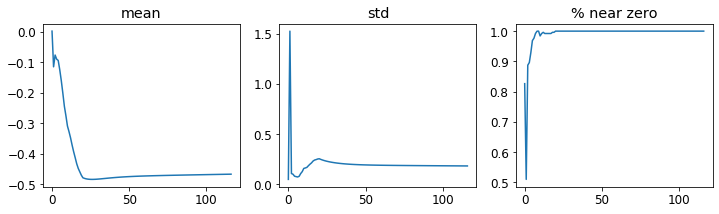

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

Again, we've got most of our activations near zero. Let's see what else we can do to improve training stability.

### 1cycle Training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we'll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

Leslie Smith (yes, the same guy that invented the learning rate finder!) developed this idea in his article ["Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates"](https://arxiv.org/abs/1708.07120). He designed a schedule for learning rate separated into two phases: one where the learning rate grows from the minimum value to the maximum value (*warmup*), and one where it decreases back to the minimum value (*annealing*). Smith called this combination of approaches *1cycle training*.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

- By training with higher learning rates, we train faster—a phenomenon Smith named *super-convergence*.
- By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

The second point is an interesting and subtle one; it is based on the observation that a model that generalizes well is one whose loss would not change very much if you changed the input by a small amount. If a model trains at a large learning rate for quite a while, and can find a good loss when doing so, it must have found an area that also generalizes well, because it is jumping around a lot from batch to batch (that is basically the definition of a high learning rate). The problem is that, as we have discussed, just jumping to a high learning rate is more likely to result in diverging losses, rather than seeing your losses improve. So we don't jump straight to a high learning rate. Instead, we start at a low learning rate, where our losses do not diverge, and we allow the optimizer to gradually find smoother and smoother areas of our parameters by gradually going to higher and higher learning rates.

Then, once we have found a nice smooth area for our parameters, we want to find the very best part of that area, which means we have to bring our learning rates down again. This is why 1cycle training has a gradual learning rate warmup, and a gradual learning rate cooldown. Many researchers have found that in practice this approach leads to more accurate models and trains more quickly. That is why it is the approach that is used by default for `fine_tune` in fastai.

In <<chapter_accel_sgd>> we'll learn all about *momentum* in SGD. Briefly, momentum is a technique where the optimizer takes a step not only in the direction of the gradients, but also that continues in the direction of previous steps. Leslie Smith introduced the idea of *cyclical momentums* in ["A Disciplined Approach to Neural Network Hyper-Parameters: Part 1"](https://arxiv.org/pdf/1803.09820.pdf). It suggests that the momentum varies in the opposite direction of the learning rate: when we are at high learning rates, we use less momentum, and we use more again in the annealing phase.

We can use 1cycle training in fastai by calling `fit_one_cycle`:

In [ ]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.210838,0.084827,0.974300,00:08


We're finally making some progress! It's giving us a reasonable accuracy now.

We can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`. `learn.recorder` (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum:

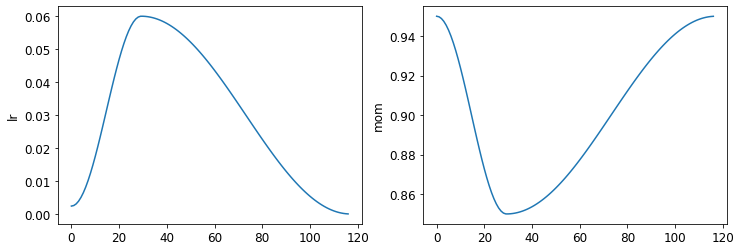

In [ ]:
learn.recorder.plot_sched()

Smith's original 1cycle paper used a linear warmup and linear annealing. As you can see, we adapted the approach in fastai by combining it with another popular approach: cosine annealing. `fit_one_cycle` provides the following parameters you can adjust:

- `lr_max`:: The highest learning rate that will be used (this can also be a list of learning rates for each layer group, or a Python `slice` object containing the first and last layer group learning rates)
- `div`:: How much to divide `lr_max` by to get the starting learning rate
- `div_final`::  How much to divide `lr_max` by to get the ending learning rate
- `pct_start`:: What percentage of the batches to use for the warmup
- `moms`:: A tuple `(mom1,mom2,mom3)` where *`mom1`* is the initial momentum, *`mom2`* is the minimum momentum, and *`mom3`* is the final momentum

Let's take a look at our layer stats again:

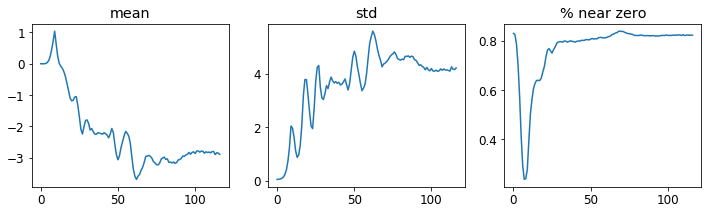

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

The percentage of near-zero weights is getting much better, although it's still quite high.

We can see even more about what's going on in our training using `color_dim`, passing it a layer index:

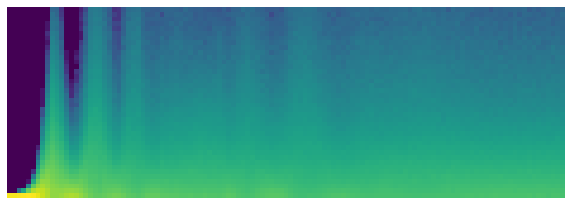

In [ ]:
learn.activation_stats.color_dim(-2)

`color_dim` was developed by fast.ai in conjunction with a student, Stefano Giomo. Stefano, who refers to the idea as the *colorful dimension*, provides an [in-depth explanation](https://forums.fast.ai/t/the-colorful-dimension/42908) of the history and details behind the method. The basic idea is to create a histogram of the activations of a layer, which we would hope would follow a smooth pattern such as the normal distribution (colorful_dist).

<img src="images/colorful_dist.jpeg" id="colorful_dist" caption="Histogram in 'colorful dimension'" alt="Histogram in 'colorful dimension'" width="800">

To create `color_dim`, we take the histogram shown on the left here, and convert it into just the colored representation shown at the bottom. Then we flip it on its side, as shown on the right. We found that the distribution is clearer if we take the log of the histogram values. Then, Stefano describes:

> : The final plot for each layer is made by stacking the histogram of the activations from each batch along the horizontal axis. So each vertical slice in the visualisation represents the histogram of activations for a single batch. The color intensity corresponds to the height of the histogram, in other words the number of activations in each histogram bin.

<<colorful_summ>> shows how this all fits together.

<img src="images/colorful_summ.png" id="colorful_summ" caption="Summary of the colorful dimension (courtesy of Stefano Giomo)" alt="Summary of the colorful dimension" width="800">

This illustrates why log(f) is more colorful than *f* when *f* follows a normal distribution because taking a log changes the Gaussian in a quadratic, which isn't as narrow.

So with that in mind, let's take another look at the result for the penultimate layer:

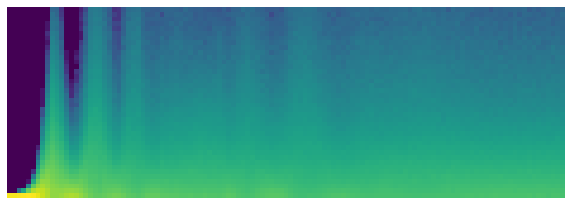

In [ ]:
learn.activation_stats.color_dim(-2)

This shows a classic picture of "bad training." We start with nearly all activations at zero—that's what we see at the far left, with all the dark blue. The bright yellow at the bottom represents the near-zero activations. Then, over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far, and collapses! We see the dark blue return, and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again, and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range.

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

### Batch Normalization

To fix the slow training and poor final results we ended up with in the previous section, we need to fix the initial large percentage of near-zero activations, and then try to maintain a good distribution of activations throughout training.

Sergey Ioffe and Christian Szegedy presented a solution to this problem in the 2015 paper ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167). In the abstract, they describe just the problem that we've seen:

> : Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their solution, they say is:

> : Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

The paper caused great excitement as soon as it was released, because it included the chart in <<batchnorm>>, which clearly demonstrated that batch normalization could train a model that was even more accurate than the current state of the art (the *Inception* architecture) and around 5x faster.

<img alt="Impact of batch normalization" width="553" caption="Impact of batch normalization (courtesy of Sergey Ioffe and Christian Szegedy)" id="batchnorm" src="images/att_00046.png">

Batch normalization (often just called *batchnorm*) works by taking an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations. However, this can cause problems because the network might want some activations to be really high in order to make accurate predictions. So they also added two learnable parameters (meaning they will be updated in the SGD step), usually called `gamma` and `beta`. After normalizing the activations to get some new activation vector `y`, a batchnorm layer returns `gamma*y + beta`.

That's why our activations can have any mean or variance, independent from the mean and standard deviation of the results of the previous layer. Those statistics are learned separately, making training easier on our model. The behavior is different during training and validation: during training, we use the mean and standard deviation of the batch to normalize the data, while during validation we instead use a running mean of the statistics calculated during training.

Let's add a batchnorm layer to `conv`:

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

and fit our model:

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.130036,0.055021,0.986400,00:10


That's a great result! Let's take a look at `color_dim`:

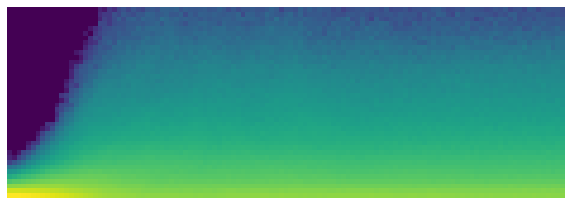

In [ ]:
learn.activation_stats.color_dim(-4)

This is just what we hope to see: a smooth development of activations, with no "crashes." Batchnorm has really delivered on its promise here! In fact, batchnorm has been so successful that we see it (or something very similar) in nearly all modern neural networks.

An interesting observation about models containing batch normalization layers is that they tend to generalize better than models that don't contain them. Although we haven't as yet seen a rigorous analysis of what's going on here, most researchers believe that the reason for this is that batch normalization adds some extra randomness to the training process. Each mini-batch will have a somewhat different mean and standard deviation than other mini-batches. Therefore, the activations will be normalized by different values each time. In order for the model to make accurate predictions, it will have to learn to become robust to these variations. In general, adding additional randomization to the training process often helps.

Since things are going so well, let's train for a few more epochs and see how it goes. In fact, let's *increase* the learning rate, since the abstract of the batchnorm paper claimed we should be able to "train at much higher learning rates":

In [ ]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.191731,0.121738,0.960900,00:11
1,0.083739,0.055808,0.981800,00:10
2,0.053161,0.044485,0.987100,00:10
3,0.034433,0.030233,0.990200,00:10
4,0.017646,0.025407,0.991200,00:10


At this point, I think it's fair to say we know how to recognize digits! It's time to move on to something harder...

## Conclusions

We've seen that convolutions are just a type of matrix multiplication, with two constraints on the weight matrix: some elements are always zero, and some elements are tied (forced to always have the same value). In <<chapter_intro>> we saw the eight requirements from the 1986 book *Parallel Distributed Processing*; one of them was "A pattern of connectivity among units." That's exactly what these constraints do: they enforce a certain pattern of connectivity.

These constraints allow us to use far fewer parameters in our model, without sacrificing the ability to represent complex visual features. That means we can train deeper models faster, with less overfitting. Although the universal approximation theorem shows that it should be *possible* to represent anything in a fully connected network in one hidden layer, we've seen now that in *practice* we can train much better models by being thoughtful about network architecture.

Convolutions are by far the most common pattern of connectivity we see in neural nets (along with regular linear layers, which we refer to as *fully connected*), but it's likely that many more will be discovered.

We've also seen how to interpret the activations of layers in the network to see whether training is going well or not, and how batchnorm helps regularize the training and makes it smoother. In the next chapter, we will use both of those layers to build the most popular architecture in computer vision: a residual network.

## Questionnaire

1. What is a "feature"?
1. Write out the convolutional kernel matrix for a top edge detector.
1. Write out the mathematical operation applied by a 3×3 kernel to a single pixel in an image.
1. What is the value of a convolutional kernel apply to a 3×3 matrix of zeros?
1. What is "padding"?
1. What is "stride"?
1. Create a nested list comprehension to complete any task that you choose.
1. What are the shapes of the `input` and `weight` parameters to PyTorch's 2D convolution?
1. What is a "channel"?
1. What is the relationship between a convolution and a matrix multiplication?
1. What is a "convolutional neural network"?
1. What is the benefit of refactoring parts of your neural network definition?
1. What is `Flatten`? Where does it need to be included in the MNIST CNN? Why?
1. What does "NCHW" mean?
1. Why does the third layer of the MNIST CNN have `7*7*(1168-16)` multiplications?
1. What is a "receptive field"?
1. What is the size of the receptive field of an activation after two stride 2 convolutions? Why?
1. Run *conv-example.xlsx* yourself and experiment with *trace precedents*.
1. Have a look at Jeremy or Sylvain's list of recent Twitter "like"s, and see if you find any interesting resources or ideas there.
1. How is a color image represented as a tensor?
1. How does a convolution work with a color input?
1. What method can we use to see that data in `DataLoaders`?
1. Why do we double the number of filters after each stride-2 conv?
1. Why do we use a larger kernel in the first conv with MNIST (with `simple_cnn`)?
1. What information does `ActivationStats` save for each layer?
1. How can we access a learner's callback after training?
1. What are the three statistics plotted by `plot_layer_stats`? What does the x-axis represent?
1. Why are activations near zero problematic?
1. What are the upsides and downsides of training with a larger batch size?
1. Why should we avoid using a high learning rate at the start of training?
1. What is 1cycle training?
1. What are the benefits of training with a high learning rate?
1. Why do we want to use a low learning rate at the end of training?
1. What is "cyclical momentum"?
1. What callback tracks hyperparameter values during training (along with other information)?
1. What does one column of pixels in the `color_dim` plot represent?
1. What does "bad training" look like in `color_dim`? Why?
1. What trainable parameters does a batch normalization layer contain?
1. What statistics are used to normalize in batch normalization during training? How about during validation?
1. Why do models with batch normalization layers generalize better?

### Further Research

1. What features other than edge detectors have been used in computer vision (especially before deep learning became popular)?
1. There are other normalization layers available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed, and how they differ from batch normalization.
1. Try moving the activation function after the batch normalization layer in `conv`. Does it make a difference? See what you can find out about what order is recommended, and why.